In [7]:
%pip install -r requirements.txt

You should consider upgrading via the '/Users/aryanlangeh/algo-trading-bot/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [56]:
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [88]:
start = datetime(2010, 8, 1)
end = datetime(2023, 8, 22)

# Replace these with the actual symbols for the data you want
# treasury_data = web.DataReader("IEF", "yahoo", start, end)  # iShares 7-10 Year Treasury Bond ETF
# fx_data = web.DataReader("DEXUSEU", "fred", start, end)  # USD/EUR exchange rate
treasury_data = yf.download("IEF", start=start, end=end) # iShares 7-10 Year Treasury Bond ETF
fx_data = yf.download("USDEUR=X", start=start, end=end) # USD/EUR exchange rate
fx_data_df = pd.DataFrame(fx_data)
treasury_data_df = pd.DataFrame(treasury_data)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [89]:
treasury_data_df['SMA_50'] = treasury_data['Close'].rolling(window=50).mean()
fx_data_df['21D_volatility'] = fx_data_df['Close'].pct_change().rolling(window=21).std()
fx_data_df['50D_SMA'] = fx_data_df['Close'].rolling(window=50).mean()


# EDA

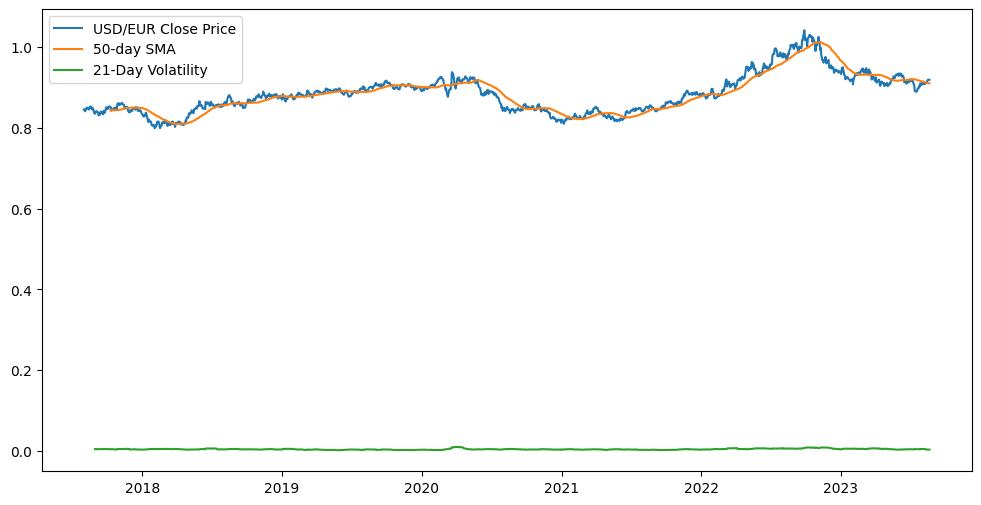

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(fx_data_df['Close'], label='USD/EUR Close Price')
plt.plot(fx_data_df['50D_SMA'], label='50-day SMA')
plt.plot(fx_data_df['21D_volatility'], label='21-Day Volatility')
plt.legend()
plt.show()

# ML

In [24]:
%pip install scikit-learn

  Using cached scikit_learn-1.3.0-cp39-cp39-macosx_10_9_x86_64.whl (10.2 MB)
  Using cached scipy-1.11.2-cp39-cp39-macosx_10_9_x86_64.whl (37.2 MB)
  Using cached threadpoolctl-3.2.0-py3-none-any.whl (15 kB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
You should consider upgrading via the '/Users/aryanlangeh/algo-trading-bot/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [90]:
from sklearn.model_selection import train_test_split

# Lag the signal to align with future price changes
fx_data_df['Target'] = fx_data_df['Close'].pct_change().shift(-1)
fx_data_df['Signal'] = (fx_data_df['Target'] > 0).astype(int)

# Prepare data for ML
X = fx_data_df[['21D_volatility', '50D_SMA']].dropna()
y = fx_data_df['Signal'].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=100, random_state=42) # 100 decision trees
#model = GradientBoostingClassifier(n_estimators=100, random_state=42) # 100 decision trees
model.fit(X_train, y_train) # Train the model

y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.4977645305514158


# Strategy

In [73]:
import backtrader as bt

class MLStrategy(bt.Strategy):
    params = (
        ('stop_loss', 0.03),
        ('take_profit', 0.05),
        ('transaction_cost', 0.001)
    )
    
    def __init__(self):
        self.order = None

    def next(self):
        close = self.data.close[0]
        volatility = self.data.volatility[0]

        features = [[close, volatility]]
        prediction = model.predict(features)[0]
        
        if self.order:  # check if an order is pending
            return
        
        if prediction == 1:
            # Buy signal
            size = self.broker.get_cash() / close
            self.order = self.buy(size=size)

            # Stop-loss and Take-profit
            self.sell(exectype=bt.Order.Stop, price=(1 - self.params.stop_loss) * close)
            self.sell(exectype=bt.Order.Limit, price=(1 + self.params.take_profit) * close)

        elif prediction == 0:
            # Sell signal
            self.order = self.sell(size=self.position.size)


# Backtesting

In [74]:
cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=treasury_data)
cerebro.adddata(data)
cerebro.addstrategy(MLStrategy)
cerebro.broker.setcommission(commission=0.001)
cerebro.run()


AttributeError: 'Lines_LineSeries_DataSeries_OHLC_OHLCDateTime_Abst' object has no attribute 'volatility'